## Bibliotecas Utilizadas

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import spacy
import regex as re
from collections import Counter
from operator import itemgetter

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud


In [61]:
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
import squarify

## Funções Auxiliares

In [62]:
# Function to remove emoji.
def emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [63]:
def tokenize(texto):
    doc = nlp.tokenizer(texto)
    return [token.lower_ for token in doc if not token.is_punct]

In [64]:
def unnest_tokens(df, # Data Frame (em linhas)
                  coluna_tokenize, # nome da coluna com os textos (tweets)
                  coluna_token_nome='palavra', # nome da coluna com os tokens
                  tokenizer_function=tokenize): # what tokenizer to use
    
    return (df[coluna_tokenize]
              .apply(tokenizer_function)
              .apply(pd.Series)
              .stack()
              .reset_index(level=0)
              .set_index('level_0')
              .rename(columns={0: coluna_token_nome})
              .join(df.drop(coluna_tokenize, 1), how='left')
              .reset_index(drop=True))

In [65]:
def clean_stopwords(df, coluna_token="palavra"):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    df = df[~ df[coluna_token].isin(stop_words_portugues | stop_words_ingles | stop_words_espanhol | symbols)]
    df = df[~ df[coluna_token].isin(w for w in df[coluna_token] if re.match(r'http*', w) != None)]
    df = df[~ df[coluna_token].isin(w for w in df[coluna_token] if emoji_pattern.match(w) != None)]
    df = df[~ df[coluna_token].isin(w for w in df[coluna_token] if (w.startswith('@') | w.startswith('#') | w.startswith('\r')))]
    df = df[~ df[coluna_token].isin(w for w in df[coluna_token] if w == 'rt')]
    return df

In [66]:
def tweet_tokenizer(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    symbols = set(['co', 'r$', 'R$', '|'])
    
    tweet = text.lower()
    tweet_token = [w for w in tokenize(tweet) if not w in (stop_words_portugues | stop_words_espanhol | stop_words_ingles | symbols)]
    tweet_token = [w for w in tweet_token if re.match(r'http*', w) == None]
    tweet_token = [w for w in tweet_token if emoji_pattern.match(w) == None]
    tweet_token = [w for w in tweet_token if not (w.startswith('@') | w.startswith('#') | w.startswith('\r'))]
    tweet_token = [w for w in tweet_token if w != 'rt']
        
    return " ".join(tweet_token)

In [67]:
def print_topic_words(model, feature_names, n_top_words, topics):
    for index, topic in enumerate(model.components_):
        if (index in topics):
            message = "\nTópico #{}:".format(index)
            message += ", ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1 :-1]])
            print(message)
            print("="*70)

In [68]:
# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

In [69]:
def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

In [70]:
def topico_politico(df, topicos):
    for i in topicos:
        print("\nTópico #{}:".format(i))
        print(df[df["Topico"]==i].groupby(["nome"]).size().sort_values(ascending=False)[:5])

## Carregando os Dados

In [71]:
# Dataframe com todos os politicos e seus tweets
lista_dir = os.listdir("./politicos/")
nome_politicos = []
df_politicos = pd.DataFrame()
for nome in lista_dir:
    df_politico = pd.read_csv(
        f"./politicos/{nome}",
        delimiter=",",
        encoding='utf-8',
        usecols=[1,2,8]
    )
    df_politico['nome'] = nome[:-4]
    nome_politicos.append(nome[:-4])
    df_politicos = df_politicos.append(df_politico)
cols = ['nome'] + [col for col in df_politicos if col != 'nome']
df_politicos = df_politicos[cols]
df_politicos.reset_index(inplace=True)

C:\Users\Roberto Tengan\anaconda3\lib\site-packages\pandas\core\indexes\base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.dtype.type, np.bool) or is_bool_dtype(data):
C:\Users\Roberto Tengan\anaconda3\lib\site-packages\pandas\core\indexes\base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.d

In [72]:
df_politicos.head(10)

index    nome            created_at  \
0      0  Amoedo  2021-04-19T16:18:20Z   
1      1  Amoedo  2021-04-19T16:05:53Z   
2      2  Amoedo  2021-04-19T15:32:40Z   
3      3  Amoedo  2021-04-19T12:53:14Z   
4      4  Amoedo  2021-04-19T12:25:58Z   
5      5  Amoedo  2021-04-19T12:19:42Z   
6      6  Amoedo  2021-04-18T19:21:07Z   
7      7  Amoedo  2021-04-18T19:21:06Z   
8      8  Amoedo  2021-04-18T15:42:35Z   
9      9  Amoedo  2021-04-18T15:42:25Z   

                                                text                   id  
0  RT @MBLivre: Presidente americano Joe Biden an...  1384179569712713735  
1  Temos que fazer a nossa parte. Não podemos dei...  1384176435552608259  
2  O governo federal e o Congresso ignoraram no O...  1384168077697314825  
3  RT @o_antagonista: .@joaoamoedonovo sugeriu no...  1384127951311040517  
4                     Informações de @OGloboPolitica  1384121090243383296  
5  A CPI da Pandemia no Senado deve investigar o ...  1384119514418216969  
6  Leia a coluna completa em https://t.co/rvNDUpnqgA  1383863178853969921  
7  "Membros do Executivo e do Legislativo não ace...  1383863176891015168  
8                       Informações de @RevistaEpoca  1383808183223734272  
9  O governo federal gastará R$500 mil em uma cam...  1383808141897342986

In [73]:
df_politicos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31633 entries, 0 to 31632
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   index       31633 non-null  int64 
 1   nome        31633 non-null  object
 2   created_at  31633 non-null  object
 3   text        31633 non-null  object
 4   id          31633 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 1.2+ MB


C:\Users\Roberto Tengan\anaconda3\lib\site-packages\pandas\core\indexes\base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.dtype.type, np.bool) or is_bool_dtype(data):
C:\Users\Roberto Tengan\anaconda3\lib\site-packages\pandas\core\indexes\base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.d

## Wordcloud e outras análises

In [74]:
# stopwords e simbolos a retirar
stop_words_portugues = set(stopwords.words('portuguese'))
stop_words_ingles = set(stopwords.words('english'))
stop_words_espanhol = set(stopwords.words('spanish'))
symbols = set(['-', 'r$', 'R$', '|'])

In [75]:
nlp = spacy.load("pt_core_news_sm")

In [76]:
# criando dataframe apenas com as palavras e os politicos
df_palavras = unnest_tokens(df_politicos.drop(['index','created_at','id'], axis=1), 'text')

C:\Users\Roberto Tengan\anaconda3\lib\site-packages\pandas\core\indexes\base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.dtype.type, np.bool) or is_bool_dtype(data):
C:\Users\Roberto Tengan\anaconda3\lib\site-packages\pandas\core\indexes\base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.d

In [77]:
df_palavras.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 905721 entries, 0 to 905720
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   palavra  905721 non-null  object
 1   nome     905721 non-null  object
dtypes: object(2)
memory usage: 13.8+ MB


C:\Users\Roberto Tengan\anaconda3\lib\site-packages\pandas\core\indexes\base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.dtype.type, np.bool) or is_bool_dtype(data):
C:\Users\Roberto Tengan\anaconda3\lib\site-packages\pandas\core\indexes\base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.d

In [78]:
df_palavras = clean_stopwords(df_palavras)

In [79]:
df_palavras.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 481396 entries, 2 to 905720
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   palavra  481396 non-null  object
 1   nome     481396 non-null  object
dtypes: object(2)
memory usage: 11.0+ MB


C:\Users\Roberto Tengan\anaconda3\lib\site-packages\pandas\core\indexes\base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.dtype.type, np.bool) or is_bool_dtype(data):
C:\Users\Roberto Tengan\anaconda3\lib\site-packages\pandas\core\indexes\base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.d

In [80]:
df_palavras.head()

palavra    nome
2  presidente  Amoedo
3   americano  Amoedo
4         joe  Amoedo
5       biden  Amoedo
6     anuncia  Amoedo

C:\Users\Roberto Tengan\anaconda3\lib\site-packages\pandas\core\indexes\base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.dtype.type, np.bool) or is_bool_dtype(data):
C:\Users\Roberto Tengan\anaconda3\lib\site-packages\pandas\core\indexes\base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.d

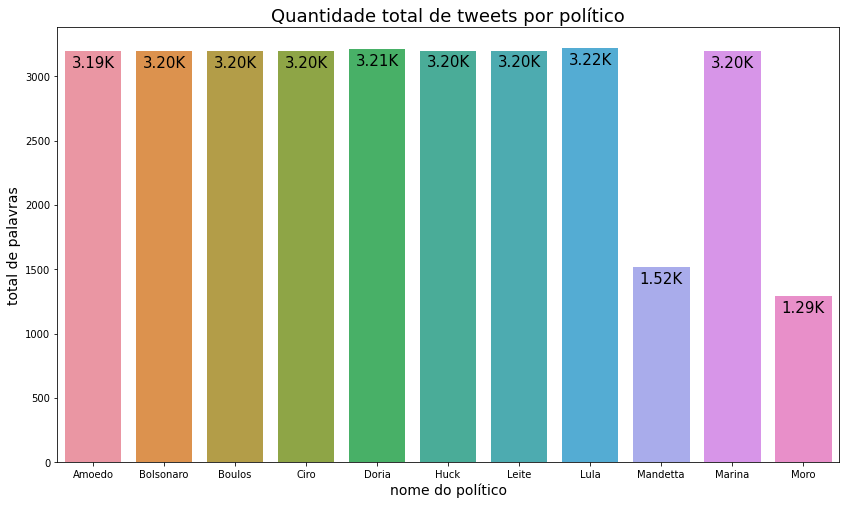

In [81]:
#quantidade de tweets por político

df_plot = df_politicos.groupby('nome').agg(total =('text','count'))
df_plot.reset_index(inplace=True)

plt.figure(figsize=(14, 8))
splot=sns.barplot(x="nome", y="total", data=df_plot)
plt.xlabel("nome do político", size=14)
plt.ylabel("total de palavras", size=14)
plt.title("Quantidade total de tweets por político", size=18)
for p in splot.patches:
    splot.annotate(format((p.get_height()/1000), '.2f')+"K", 
                  (p.get_x() + p.get_width() / 2., p.get_height()), 
                  ha = 'center', va = 'center', 
                  size=15,
                  xytext = (0, -12), 
                  textcoords = 'offset points')

C:\Users\Roberto Tengan\anaconda3\lib\site-packages\pandas\core\indexes\base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.dtype.type, np.bool) or is_bool_dtype(data):
C:\Users\Roberto Tengan\anaconda3\lib\site-packages\pandas\core\indexes\base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.d

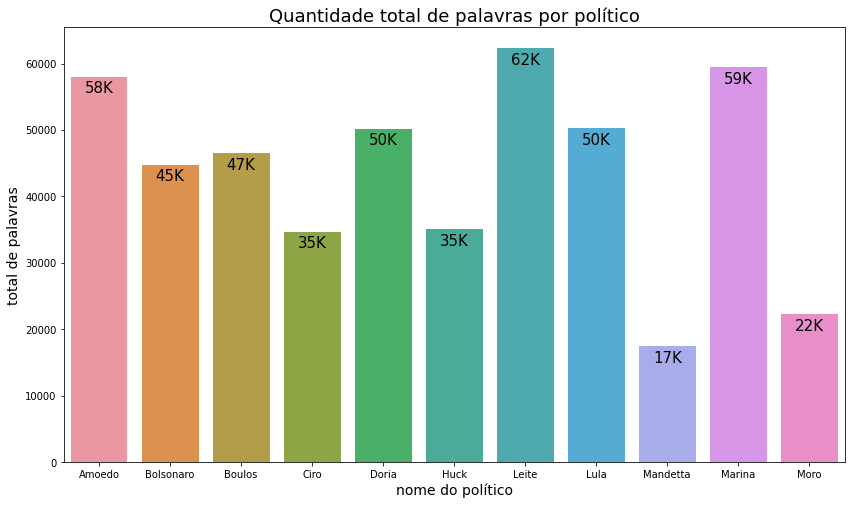

In [82]:
# quantidade de palavras por político

df_plot = df_palavras.groupby('nome').agg(total =('palavra','count'))
df_plot.reset_index(inplace=True)

plt.figure(figsize=(14, 8))
splot=sns.barplot(x="nome", y="total", data=df_plot)
plt.xlabel("nome do político", size=14)
plt.ylabel("total de palavras", size=14)
plt.title("Quantidade total de palavras por político", size=18)
for p in splot.patches:
    splot.annotate(format(round(p.get_height()/1000), '.0f')+"K", 
                  (p.get_x() + p.get_width() / 2., p.get_height()), 
                  ha = 'center', va = 'center', 
                  size=15,
                  xytext = (0, -12), 
                  textcoords = 'offset points')

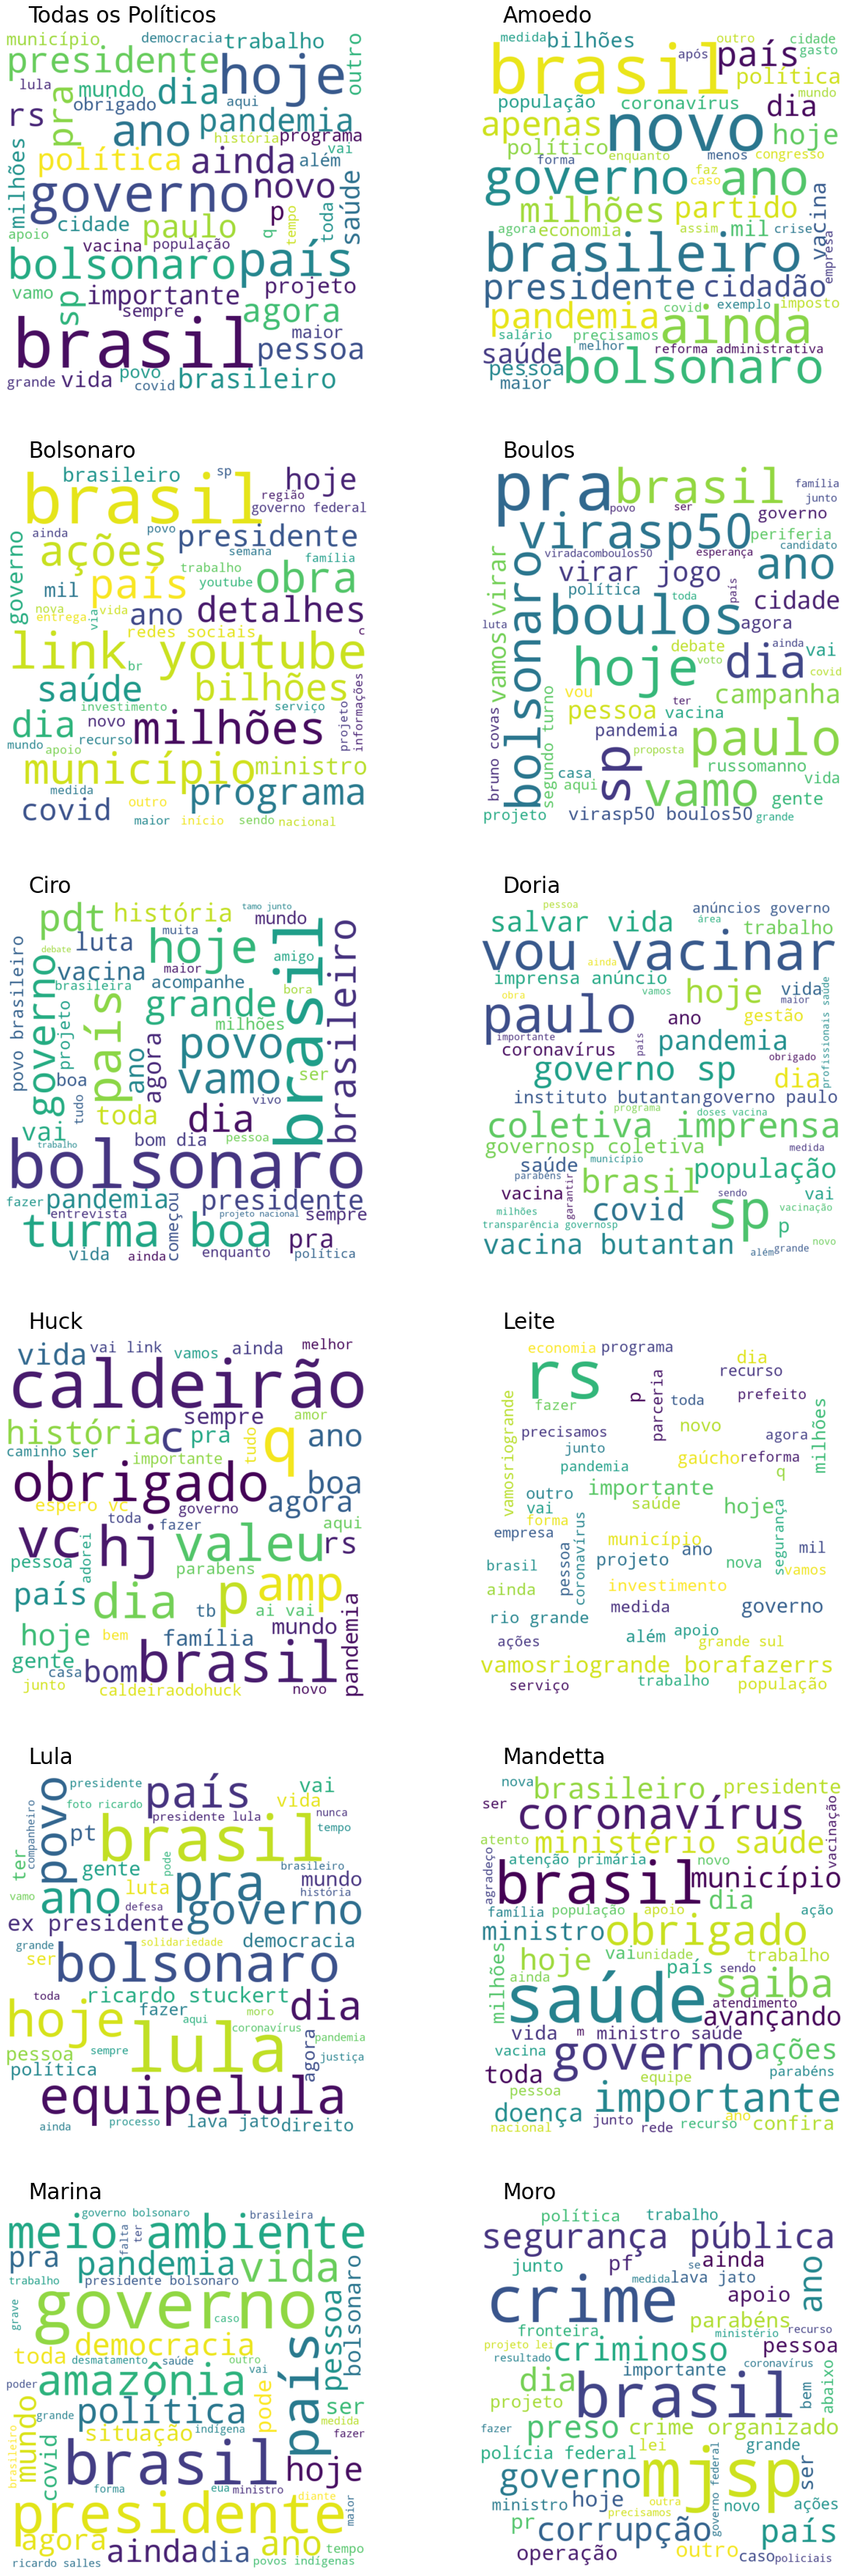

In [83]:
# wordcloud por político
fig, ax = plt.subplots(nrows=6, ncols=2, figsize=(20, 60), facecolor='w')
xc = 0
yc = 1
sumario = " ".join(s for s in df_palavras['palavra'])
wordcloud = WordCloud(width=800, height=800, max_words=50, max_font_size=150, background_color='white').generate(sumario)
ax[0][0].imshow(wordcloud, interpolation="bilinear")
ax[0][0].text(50, -20, 'Todas os Políticos', fontsize=28, color='k')
ax[0][0].axis('off')

for idx in range(11):
    sumario = " ".join(s for s in df_palavras['palavra'][df_palavras['nome'] == nome_politicos[idx]])
    wordcloud = WordCloud(width=800, height=800, max_words=50, max_font_size=150, 
            background_color='white').generate(sumario)      
    ax[xc][yc].imshow(wordcloud, interpolation="bilinear")
    ax[xc][yc].text(50, -20, nome_politicos[idx], fontsize=28, color='black')
    ax[xc][yc].axis('off')
    yc += 1
    if (yc == 2):
        yc = 0
        xc += 1
        if (xc == 6):
            xc = 0

plt.show()

## Análise de frequências

In [84]:
# montando dataframe de frequências

c = Counter(df_palavras['palavra']).most_common()
df_palavras_qtd = pd.DataFrame(c, columns=['palavra', 'qtd'])
for politico in nome_politicos:
    c = Counter(df_palavras['palavra'][df_palavras['nome'] == politico]).most_common()
    d = pd.DataFrame(c, columns=['palavra', politico])
    #d[f'f-{politico}'] = d[politico] / df_palavras_qtd['qtd']
    df_palavras_qtd = pd.merge(df_palavras_qtd, d, on='palavra')

C:\Users\Roberto Tengan\anaconda3\lib\site-packages\pandas\core\internals\construction.py:587: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if dtype != object and dtype != np.object:
C:\Users\Roberto Tengan\anaconda3\lib\site-packages\pandas\core\internals\construction.py:587: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if dtype != object and dtype != np.object:
C:\Users\Roberto Tengan\anaconda3\lib\site-packages\pandas\core\indexes\base.py:395: DeprecationWarning: `np.b

In [85]:
df_palavras_qtd

palavra   qtd  Amoedo  Bolsonaro  Boulos  Ciro  Doria  Huck  Leite  \
0       brasil  3492     529        406     211   461    248   226    100   
1      governo  2907     292        240     160   213    470    35    284   
2         hoje  2275     142        116     284   237    319   125    423   
3        saúde  2040     212        152     121   149    337    88    227   
4    bolsonaro  2032     276         77     285   618     39     1      6   
..         ...   ...     ...        ...     ...   ...    ...   ...    ...   
940   terceiro    26       4          1       1     3      3     3      2   
941     chegam    24       2          5       1     1      4     2      1   
942    desejar    22       1          1       3     5      2     2      1   
943    pequena    21       4          3       2     1      1     1      2   
944  brilhante    19       1          1       1     2      7     1      1   

     Lula  Mandetta  Marina  Moro  
0     483       197     488   143  
1     215       153     715   130  
2     290        70     208    61  
3     104       445     186    19  
4     361        17     340    12  
..    ...       ...     ...   ...  
940     3         3       1     2  
941     2         2       3     1  
942     1         3       1     2  
943     1         2       3     1  
944     2         1       1     1  

[945 rows x 13 columns]

In [86]:
df_palavras_freq = df_palavras_qtd.copy()
for politico in nome_politicos:
     df_palavras_freq[politico] =  df_palavras_qtd[politico]/df_palavras_qtd['qtd']

df_palavras_freq

palavra   qtd    Amoedo  Bolsonaro    Boulos      Ciro     Doria  \
0       brasil  3492  0.151489   0.116266  0.060424  0.132016  0.071019   
1      governo  2907  0.100447   0.082559  0.055040  0.073271  0.161679   
2         hoje  2275  0.062418   0.050989  0.124835  0.104176  0.140220   
3        saúde  2040  0.103922   0.074510  0.059314  0.073039  0.165196   
4    bolsonaro  2032  0.135827   0.037894  0.140256  0.304134  0.019193   
..         ...   ...       ...        ...       ...       ...       ...   
940   terceiro    26  0.153846   0.038462  0.038462  0.115385  0.115385   
941     chegam    24  0.083333   0.208333  0.041667  0.041667  0.166667   
942    desejar    22  0.045455   0.045455  0.136364  0.227273  0.090909   
943    pequena    21  0.190476   0.142857  0.095238  0.047619  0.047619   
944  brilhante    19  0.052632   0.052632  0.052632  0.105263  0.368421   

         Huck     Leite      Lula  Mandetta    Marina      Moro  
0    0.064719  0.028637  0.138316  0.056415  0.139748  0.040951  
1    0.012040  0.097695  0.073959  0.052632  0.245958  0.044720  
2    0.054945  0.185934  0.127473  0.030769  0.091429  0.026813  
3    0.043137  0.111275  0.050980  0.218137  0.091176  0.009314  
4    0.000492  0.002953  0.177657  0.008366  0.167323  0.005906  
..        ...       ...       ...       ...       ...       ...  
940  0.115385  0.076923  0.115385  0.115385  0.038462  0.076923  
941  0.083333  0.041667  0.083333  0.083333  0.125000  0.041667  
942  0.090909  0.045455  0.045455  0.136364  0.045455  0.090909  
943  0.047619  0.095238  0.047619  0.095238  0.142857  0.047619  
944  0.052632  0.052632  0.105263  0.052632  0.052632  0.052632  

[945 rows x 13 columns]

C:\Users\Roberto Tengan\anaconda3\lib\site-packages\seaborn\categorical.py:332: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(s, dtype=np.float)
C:\Users\Roberto Tengan\anaconda3\lib\site-packages\seaborn\categorical.py:332: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(s, dtype=np.float)
C:\Users\Roberto Tengan\anac

Text(0.5, 1.0, 'Frequência das palavras')

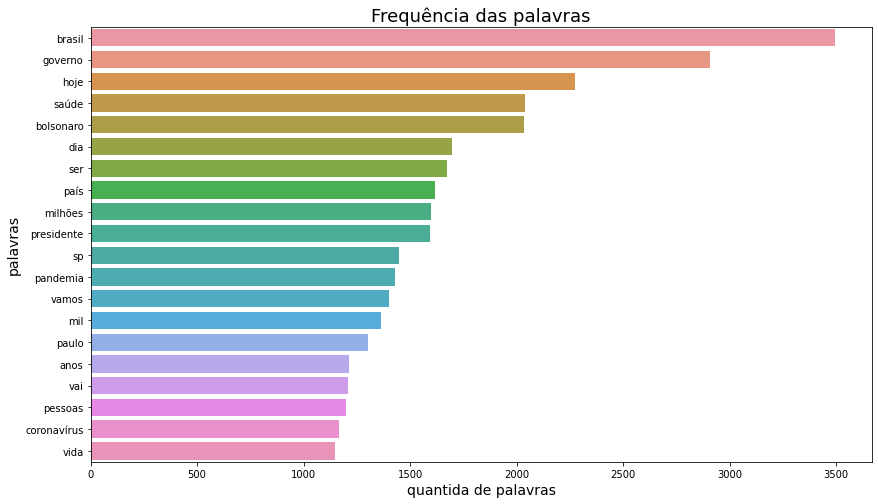

In [87]:
# quantidade de palavras por político
df_plot = df_palavras_freq[:20]

plt.figure(figsize=(14, 8))
splot=sns.barplot(x="qtd", y="palavra", data=df_plot)
plt.xlabel("quantida de palavras", size=14)
plt.ylabel("palavras", size=14)
plt.title("Frequência das palavras", size=18)

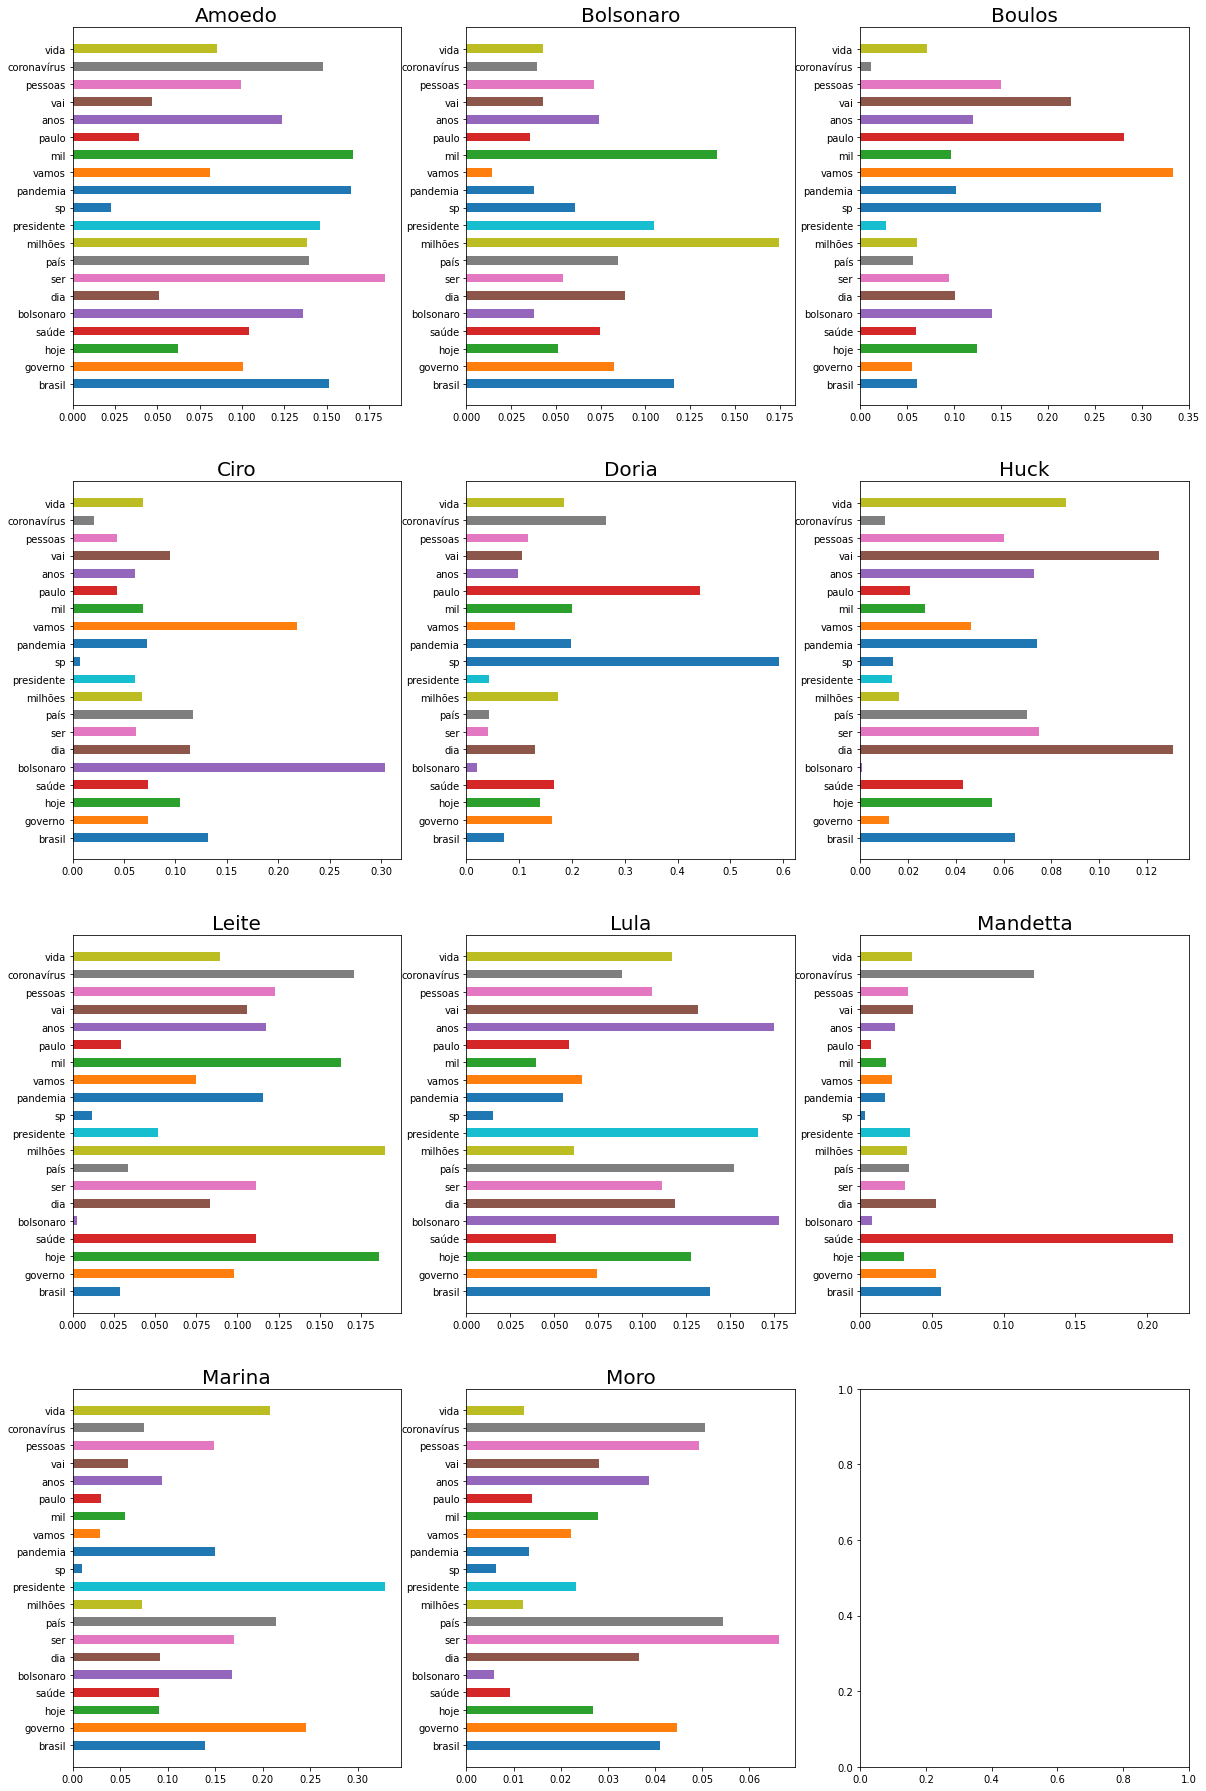

In [88]:
colors = [f'C{x}' for x in range(11)]
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(20, 32), facecolor='w')
xc=0
yc=0
for idx in range(11):
    ax[xc][yc].barh(y=df_plot['palavra'], width=df_plot[nome_politicos[idx]], height=0.5, color=colors)
    ax[xc][yc].set_title(nome_politicos[idx], fontsize=20, color='black')
    yc += 1
    if (yc == 3):
        yc = 0
        xc += 1
        if (xc == 6):
            xc = 0

plt.show()

## LDA - Latent Dirichlet Allocation - Modelagem de Tópicos

In [89]:
df_politicos['tweet_token'] = df_politicos['text'].apply(tweet_tokenizer)
df_politicos.head()

C:\Users\Roberto Tengan\anaconda3\lib\site-packages\pandas\core\indexes\base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.dtype.type, np.bool) or is_bool_dtype(data):
C:\Users\Roberto Tengan\anaconda3\lib\site-packages\pandas\core\indexes\base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.d

index    nome            created_at  \
0      0  Amoedo  2021-04-19T16:18:20Z   
1      1  Amoedo  2021-04-19T16:05:53Z   
2      2  Amoedo  2021-04-19T15:32:40Z   
3      3  Amoedo  2021-04-19T12:53:14Z   
4      4  Amoedo  2021-04-19T12:25:58Z   

                                                text                   id  \
0  RT @MBLivre: Presidente americano Joe Biden an...  1384179569712713735   
1  Temos que fazer a nossa parte. Não podemos dei...  1384176435552608259   
2  O governo federal e o Congresso ignoraram no O...  1384168077697314825   
3  RT @o_antagonista: .@joaoamoedonovo sugeriu no...  1384127951311040517   
4                     Informações de @OGloboPolitica  1384121090243383296   

                                         tweet_token  
0  presidente americano joe biden anuncia hoje va...  
1  fazer parte podemos deixar brasil continuar an...  
2  governo federal congresso ignoraram orçamento ...  
3  .@joaoamoedonovo sugeriu twitter temas serem i...  
4                                        informações

In [90]:
tf_vectorizer = CountVectorizer()
tf = tf_vectorizer.fit_transform(list(df_politicos['tweet_token']))
                                
# Materialize the sparse data
data_dense = tf.todense()

print("% Esparsa: ", round(((data_dense > 0).sum()/data_dense.size)*100, 2), "%")

% Esparsa:  0.04 %


## Grid Search (Hyper Parameter Tunning)

In [32]:
# Define Search Param
#search_params = {'n_components':[22, 33, 44, 55, 66], 'learning_decay': [.3, .5, .7, .9, 1]}

# Init the Model
#lda = LatentDirichletAllocation()

# Init Grid Search Class
#model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
#model.fit(tf)

GridSearchCV(estimator=LatentDirichletAllocation(),
             param_grid={'learning_decay': [0.3, 0.5, 0.7, 0.9, 1],
                         'n_components': [22, 33, 44, 55, 66]})

In [33]:
# Melhor modelo
#lda = model.best_estimator_

# Hiperparâmetros do modelo
#print("Melhores parâmetros: ", model.best_params_)

# probabilidade logarítmica
#print("Melhor score de probabilidade logarítmica: ", model.best_score_)

# Perplexidade
#print("Perplexidade do modelo: ", lda.perplexity(tf))

Melhores parâmetros:  {'learning_decay': 0.5, 'n_components': 22}
Melhor score de probabilidade logarítmica:  -835849.9186294072
Perplexidade do modelo:  2557.516520220409


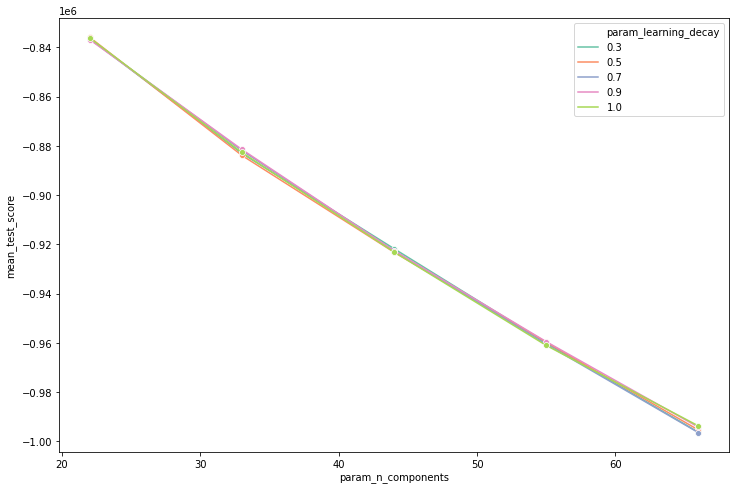

In [34]:
#results = pd.DataFrame(model.cv_results_)

#current_palette = sns.color_palette("Set2", 5)
#plt.figure(figsize=(12,8))
#sns.lineplot(data=results,
#             x='param_n_components',
#             y='mean_test_score',
#             hue='param_learning_decay',
#             palette=current_palette,
#             marker='o'
#            )

#plt.show()

In [91]:
lda = LatentDirichletAllocation(n_components=22,
                                learning_decay = 0.5,
                                random_state = 30)
lda_output = lda.fit_transform(tf)

In [92]:
# Probabilidade logaritmica: quanto maior melhor
print("probabilidade logaritmica: ", round(lda.score(tf), 2))

# Perplexidade: menor melhor.  exp(-1. * log-Probabilidade logaritmica por palavra)
print("Perplexidade: ", round(lda.perplexity(tf), 2))

print("Parâmetros:")
print(lda.get_params())

probabilidade logaritmica:  -4320891.46
Perplexidade:  8462.82
Parâmetros:
{'batch_size': 128, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.5, 'learning_method': 'batch', 'learning_offset': 10.0, 'max_doc_update_iter': 100, 'max_iter': 10, 'mean_change_tol': 0.001, 'n_components': 22, 'n_jobs': None, 'perp_tol': 0.1, 'random_state': 30, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 0}


In [93]:
# column names
topicnames = ["Topic" + str(i) for i in range(lda.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(df_politicos))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Apply Style
df_document_topics = df_document_topic.style.applymap(color_green).applymap(make_bold)
df_document_topics_first10 = df_document_topic[:10].style.applymap(color_green).applymap(make_bold)
df_document_topics_first10

C:\Users\Roberto Tengan\anaconda3\lib\site-packages\pandas\core\indexes\base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.dtype.type, np.bool) or is_bool_dtype(data):
C:\Users\Roberto Tengan\anaconda3\lib\site-packages\pandas\core\indexes\base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.d

In [94]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution.head(5)

C:\Users\Roberto Tengan\anaconda3\lib\site-packages\pandas\core\indexes\base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.dtype.type, np.bool) or is_bool_dtype(data):
C:\Users\Roberto Tengan\anaconda3\lib\site-packages\pandas\core\indexes\base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.d

Topic Num  Num Documents
0          0           2556
1          5           2354
2          6           2254
3         14           2224
4         20           2096

In [38]:
top_topics = df_topic_distribution['Topic Num'][:5].tolist()
n_top_words = 10
print("\nTop 5 Tópicos do Modelo LDA: ")
print("*"*70)
tf_feature_names = tf_vectorizer.get_feature_names()
print_topic_words(lda, tf_feature_names, n_top_words, top_topics)


Top 5 Tópicos do Modelo LDA: 
**********************************************************************

Tópico #0:milhões, co, bilhões, mil, renda, governo, sp, auxílio, população, pessoas

Tópico #6:co, pra, povo, brasil, dia, país, gente, luta, vida, anos

Tópico #15:co, lula, entrevista, vivo, equipelula, presidente, hoje, lulaoficial, ex, jato

Tópico #16:co, youtube, boa, link, dia, turma, hoje, agora, live, bom

Tópico #18:co, saúde, minsaude, governo, federal, ações, municípios, milhões, segurança, combate


In [39]:
df2 = pd.DataFrame(data=df_document_topics.data, columns=df_document_topics.columns)
df_politicos["Topico"] = df2["dominant_topic"].tolist()
df_politicos.head()

index    nome            created_at  \
0      0  Amoedo  2021-04-19T16:18:20Z   
1      1  Amoedo  2021-04-19T16:05:53Z   
2      2  Amoedo  2021-04-19T15:32:40Z   
3      3  Amoedo  2021-04-19T12:53:14Z   
4      4  Amoedo  2021-04-19T12:25:58Z   

                                                text                   id  \
0  RT @MBLivre: Presidente americano Joe Biden an...  1384179569712713735   
1  Temos que fazer a nossa parte. Não podemos dei...  1384176435552608259   
2  O governo federal e o Congresso ignoraram no O...  1384168077697314825   
3  RT @o_antagonista: .@joaoamoedonovo sugeriu no...  1384127951311040517   
4                     Informações de @OGloboPolitica  1384121090243383296   

                                         tweet_token  Topico  
0  mblivre presidente americano joe biden anuncia...       4  
1  fazer parte podemos deixar brasil continuar an...       8  
2  governo federal congresso ignoraram orçamento ...       0  
3  o_antagonista joaoamoedonovo sugeriu twitter t...      14  
4                         informações oglobopolitica      15

In [41]:
df_politicos.groupby(["Topico"])['nome'].agg(pd.Series.mode).to_frame()

nome
Topico           
0          Boulos
1           Doria
2            Ciro
3           Doria
4          Amoedo
5            Lula
6            Huck
7          Marina
8            Moro
9          Amoedo
10           Lula
11      Bolsonaro
12         Amoedo
13          Doria
14         Amoedo
15          Leite
16         Boulos
17         Boulos
18           Ciro
19          Leite
20         Marina
21      Bolsonaro

In [40]:
topico_politico(df_politicos, top_topics)


Tópico #0:
nome
Leite        584
Doria        513
Amoedo       413
Bolsonaro    336
Boulos       255
dtype: int64

Tópico #18:
nome
Bolsonaro    708
Leite        457
Mandetta     322
Moro         264
Doria        177
dtype: int64

Tópico #15:
nome
Lula         867
Huck         323
Boulos       227
Ciro         173
Bolsonaro    132
dtype: int64

Tópico #6:
nome
Lula      610
Ciro      330
Boulos    282
Amoedo    258
Huck      243
dtype: int64

Tópico #16:
nome
Ciro         597
Huck         380
Bolsonaro    282
Lula         202
Amoedo       187
dtype: int64


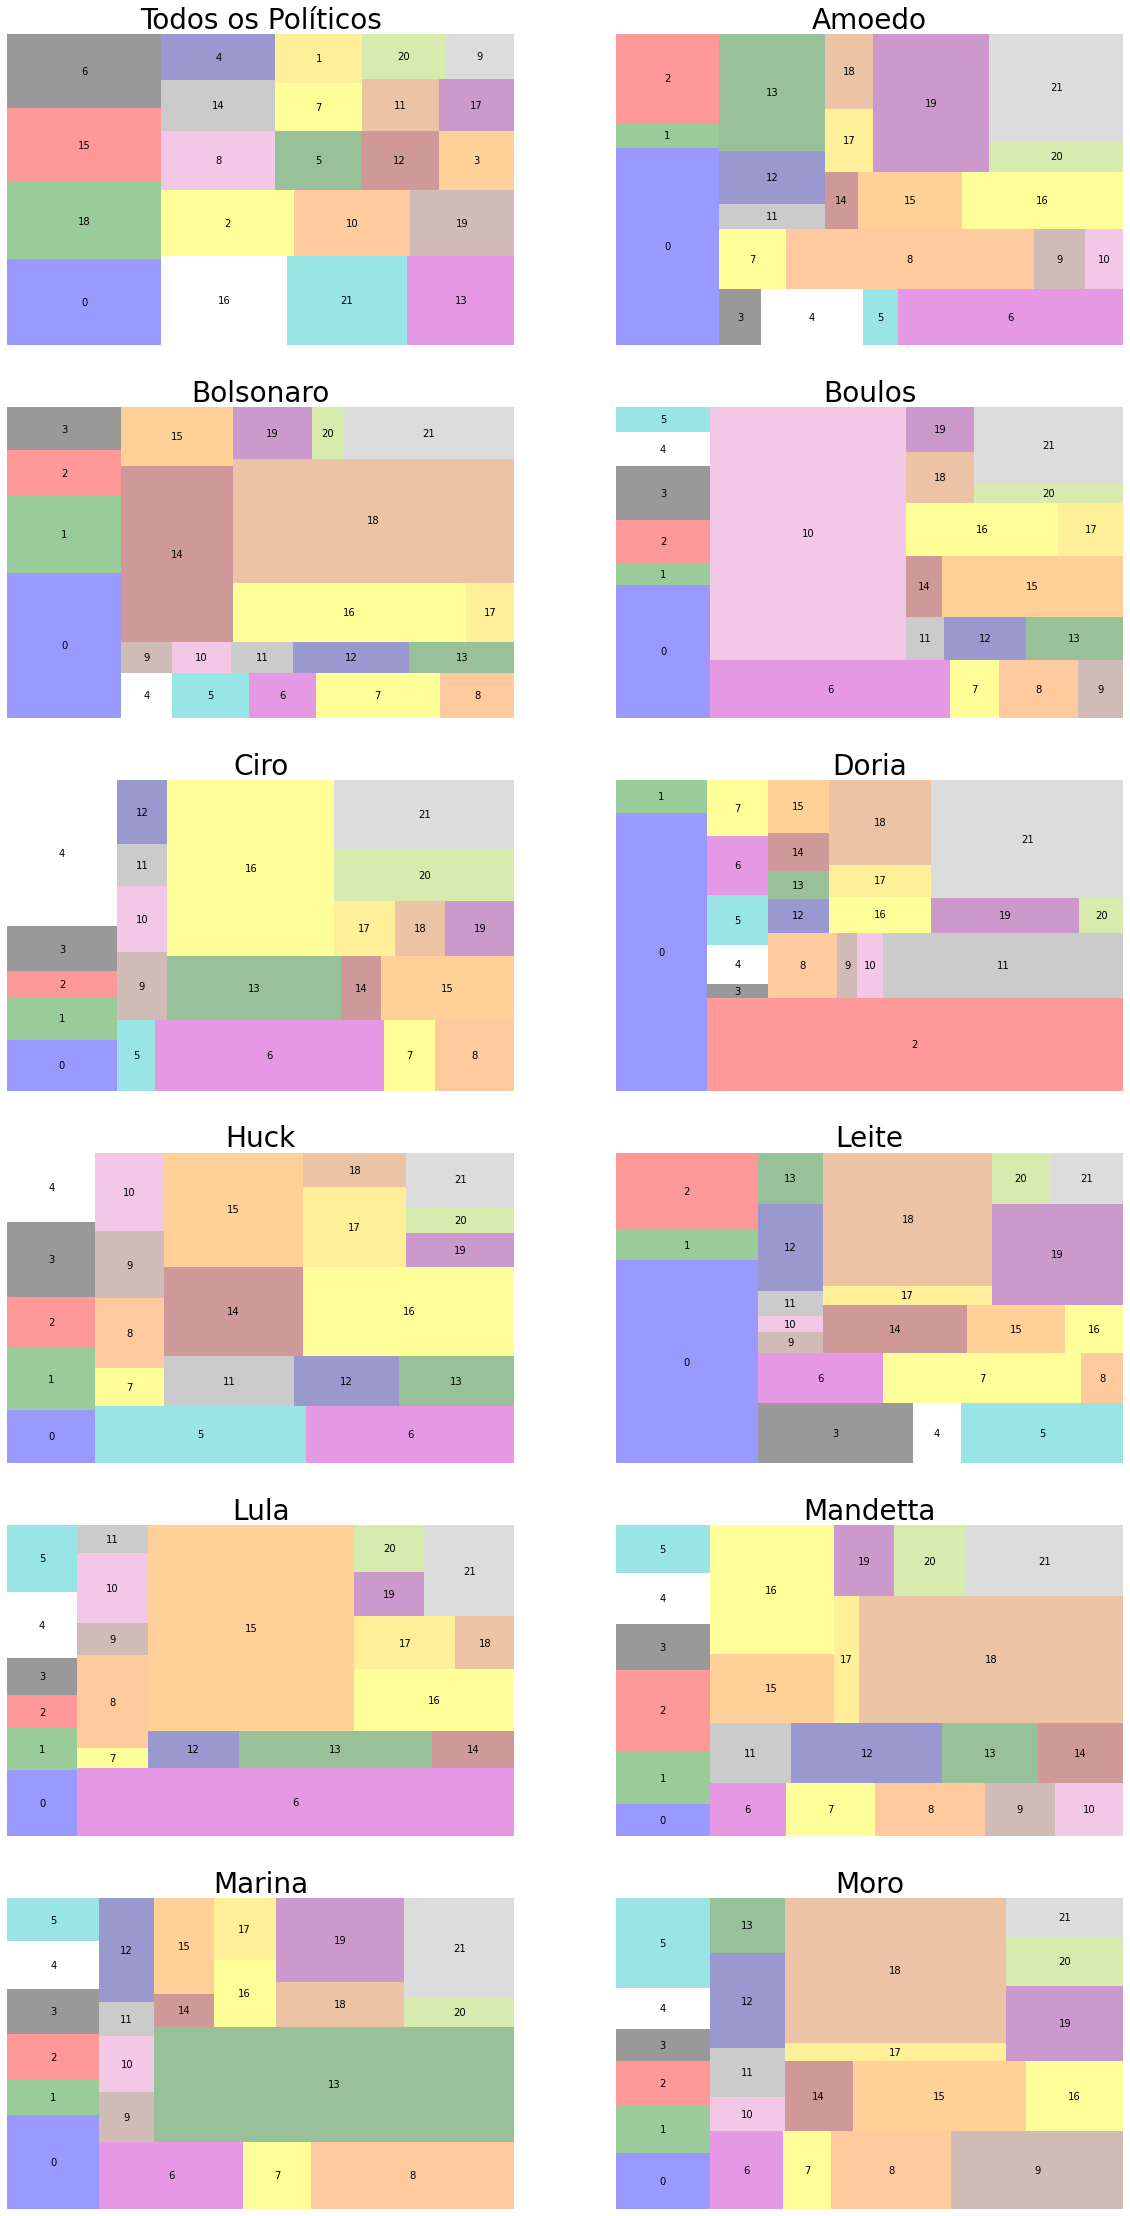

In [41]:
# treemap por politico
fig, ax = plt.subplots(nrows=6, ncols=2, figsize=(20, 40), facecolor='w')
# Cores para cada tópico
colors = ['b', 'g', 'r', 'k', 'w', 'c', 'm', 'yellow', 'tab:orange', 'tab:brown', 'tab:pink', 
                     'tab:gray', 'darkblue', 'darkgreen', 'darkred', 'darkorange', 'yellow', 'gold', 'chocolate',
                     'purple', 'yellowgreen', 'darkgrey']
xc = 0
yc = 1
# Treemap contagem de tópicos Geral
squarify.plot(sizes=df_topic_distribution['Num Documents'], ax=ax[0][0], label=df_topic_distribution['Topic Num'], alpha=.4, color=colors)
ax[0][0].set_title('Todos os Políticos', fontsize=28, color='black')
ax[0][0].axis('off')

# Itera a lista de politicos para gerar Treemap de cada politico com seus tópicos
for idx in range(11):
    dfTopicos = df_politicos[df_politicos["nome"]==nome_politicos[idx]].groupby(["Topico"]).size().to_frame().reset_index("Topico")
    dfTopicos.columns = ['Topico', 'Quantidade']
    squarify.plot(sizes=dfTopicos['Quantidade'], ax=ax[xc][yc], label=dfTopicos['Topico'], alpha=.4, color=colors)
    ax[xc][yc].set_title(nome_politicos[idx], fontsize=28, color='black')
    ax[xc][yc].axis('off')
    yc += 1
    if (yc >= 2):
        yc = 0
        xc += 1
        if (xc >= 6):
            xc = 0   
#plt.axis('off')
plt.show()

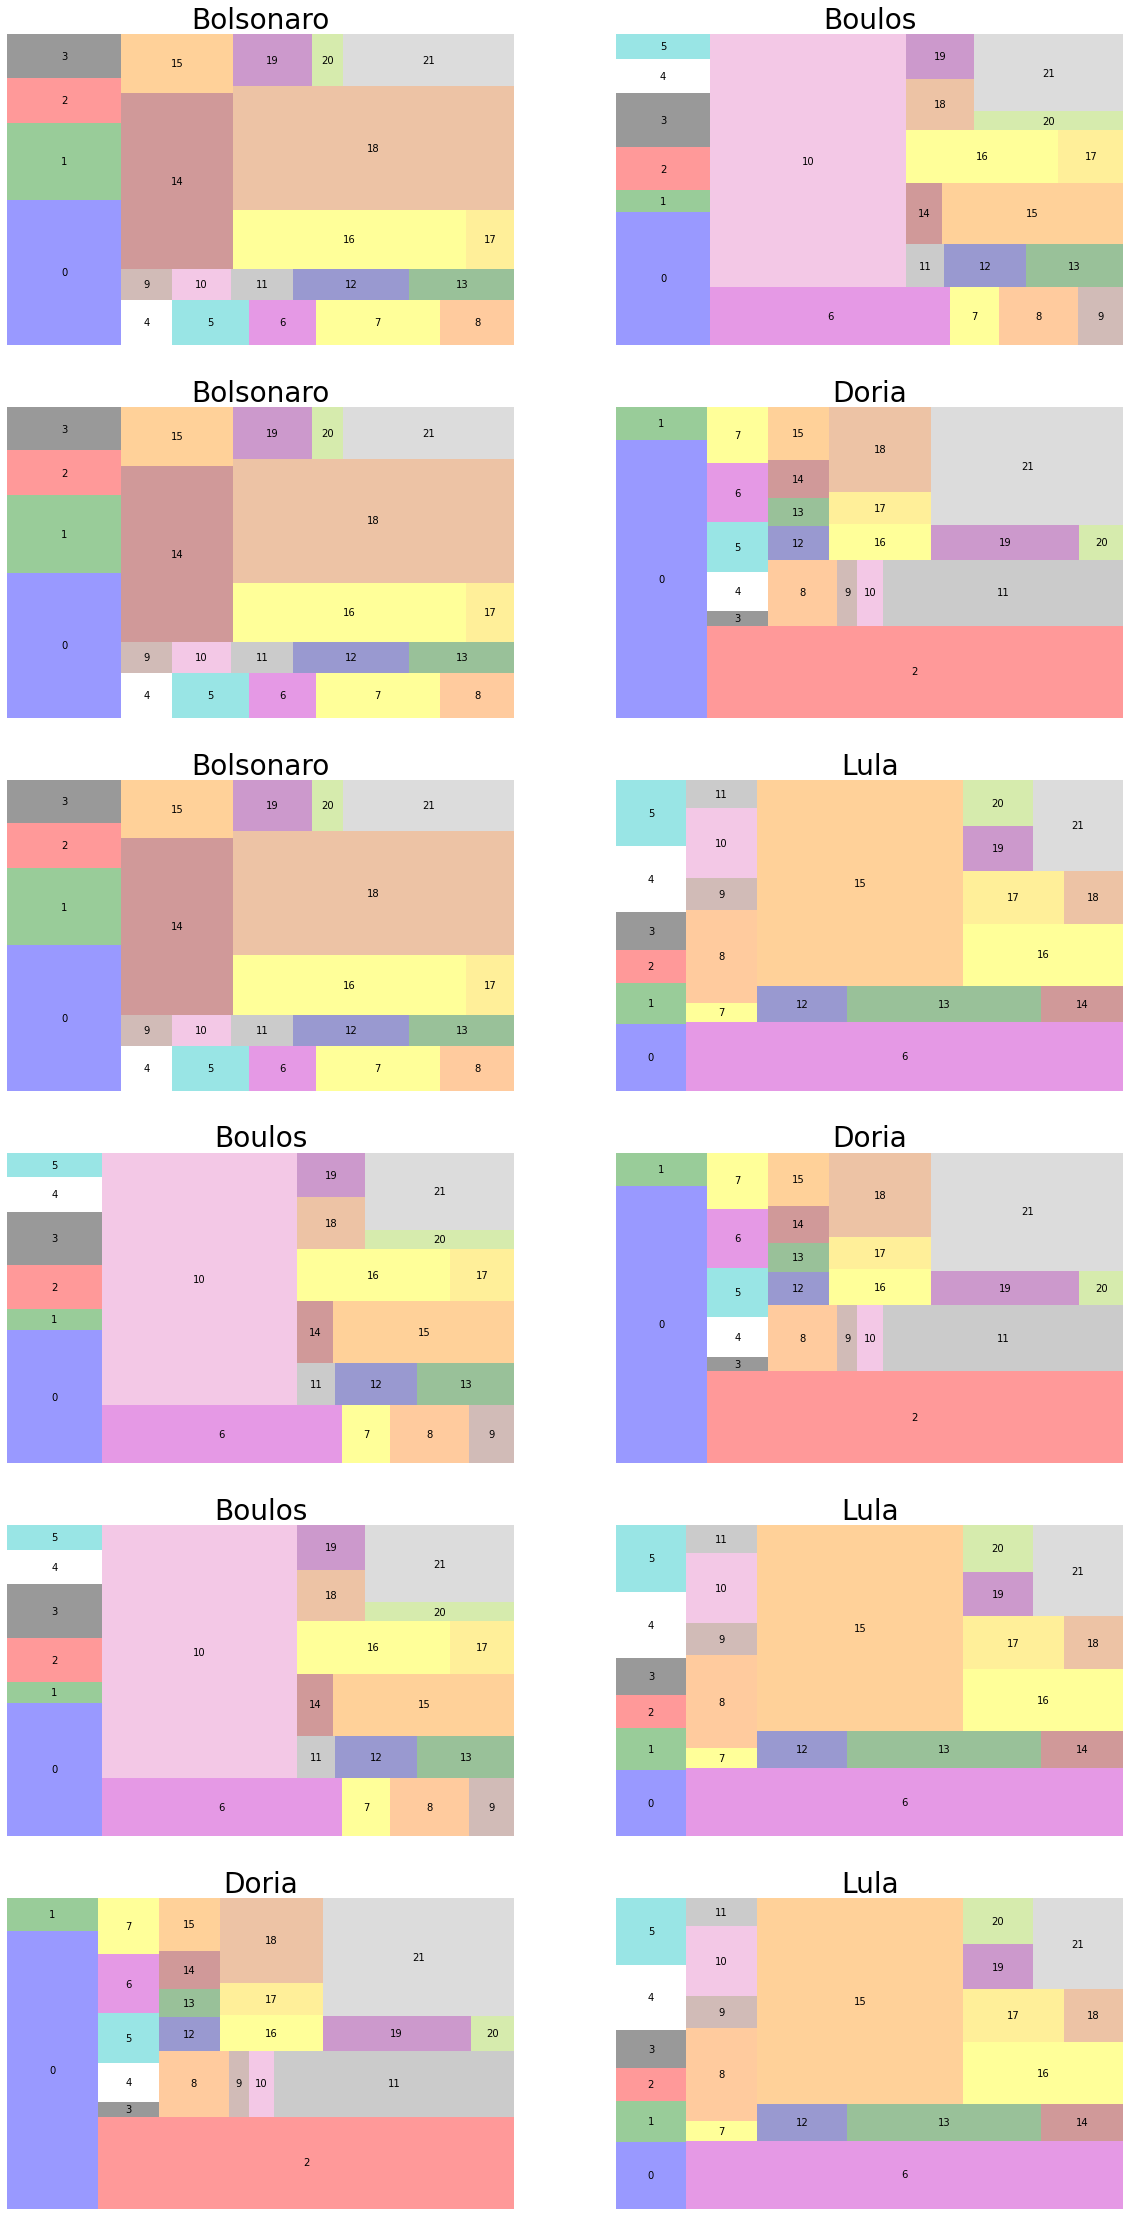

In [42]:
fig, ax = plt.subplots(nrows=6, ncols=2, figsize=(20, 40), facecolor='w')

dfBolsonaro = df_politicos[df_politicos["nome"]=='Bolsonaro'].groupby(["Topico"]).size().to_frame().reset_index("Topico")
dfBolsonaro.columns = ['Topico', 'Quantidade']

dfBoulos = df_politicos[df_politicos["nome"]=='Boulos'].groupby(["Topico"]).size().to_frame().reset_index("Topico")
dfBoulos.columns = ['Topico', 'Quantidade']

dfDoria = df_politicos[df_politicos["nome"]=='Doria'].groupby(["Topico"]).size().to_frame().reset_index("Topico")
dfDoria.columns = ['Topico', 'Quantidade']

dfLula = df_politicos[df_politicos["nome"]=='Lula'].groupby(["Topico"]).size().to_frame().reset_index("Topico")
dfLula.columns = ['Topico', 'Quantidade']

squarify.plot(sizes=dfBolsonaro['Quantidade'], label=dfBolsonaro['Topico'], color=colors, alpha=.4, ax=ax[0][0])
ax[0][0].set_title('Bolsonaro', fontsize=28, color='black')
ax[0][0].axis('off')

squarify.plot(sizes=dfBoulos['Quantidade'], label=dfBoulos['Topico'], color=colors, alpha=.4, ax=ax[0][1])
ax[0][1].set_title('Boulos', fontsize=28, color='black')
ax[0][1].axis('off')

squarify.plot(sizes=dfBolsonaro['Quantidade'], label=dfBolsonaro['Topico'], color=colors, alpha=.4, ax=ax[1][0])
ax[1][0].set_title('Bolsonaro', fontsize=28, color='black')
ax[1][0].axis('off')

squarify.plot(sizes=dfDoria['Quantidade'], label=dfDoria['Topico'], color=colors, alpha=.4, ax=ax[1][1])
ax[1][1].set_title('Doria', fontsize=28, color='black')
ax[1][1].axis('off')

squarify.plot(sizes=dfBolsonaro['Quantidade'], label=dfBolsonaro['Topico'], color=colors, alpha=.4, ax=ax[2][0])
ax[2][0].set_title('Bolsonaro', fontsize=28, color='black')
ax[2][0].axis('off')

squarify.plot(sizes=dfLula['Quantidade'], label=dfLula['Topico'], color=colors, alpha=.4, ax=ax[2][1])
ax[2][1].set_title('Lula', fontsize=28, color='black')
ax[2][1].axis('off')

squarify.plot(sizes=dfBoulos['Quantidade'], label=dfBoulos['Topico'], color=colors, alpha=.4, ax=ax[3][0])
ax[3][0].set_title('Boulos', fontsize=28, color='black')
ax[3][0].axis('off')

squarify.plot(sizes=dfDoria['Quantidade'], label=dfDoria['Topico'], color=colors, alpha=.4, ax=ax[3][1])
ax[3][1].set_title('Doria', fontsize=28, color='black')
ax[3][1].axis('off')

squarify.plot(sizes=dfBoulos['Quantidade'], label=dfBoulos['Topico'], color=colors, alpha=.4, ax=ax[4][0])
ax[4][0].set_title('Boulos', fontsize=28, color='black')
ax[4][0].axis('off')

squarify.plot(sizes=dfLula['Quantidade'], label=dfLula['Topico'], color=colors, alpha=.4, ax=ax[4][1])
ax[4][1].set_title('Lula', fontsize=28, color='black')
ax[4][1].axis('off')

squarify.plot(sizes=dfDoria['Quantidade'], label=dfDoria['Topico'], color=colors, alpha=.4, ax=ax[5][0])
ax[5][0].set_title('Doria', fontsize=28, color='black')
ax[5][0].axis('off')

squarify.plot(sizes=dfLula['Quantidade'], label=dfLula['Topico'], color=colors, alpha=.4, ax=ax[5][1])
ax[5][1].set_title('Lula', fontsize=28, color='black')
ax[5][1].axis('off')

plt.show()

In [59]:
#import pyLDAvis.sklearn
#pyLDAvis.enable_notebook()
#dash = pyLDAvis.sklearn.prepare(lda, tf, tf_vectorizer, mds = 'pcoa')
#dash
print(1)

1
